## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import nltk.tokenize
import itertools
import datetime
import torch

from sklearn.model_selection import train_test_split

from pathlib import Path

from fastai import *
from fastai.text import *

from copy import copy, deepcopy
from enum import Enum

### Model definitions
Define this notebooks "initializer model" (pretrained parameters and itos mapping) and the output model as well.

In [2]:
model_name = '4.0-LM-108k-lines'
MODEL_PATH = Path(f'../data/models/{model_name}')
MODEL_PATH.mkdir(exist_ok=True)

init_model_name = 'wt103'
INIT_MODEL_PATH = Path(f'../data/models/{init_model_name}')

### Tokenization
To create the model's tokens with the correct train-test split, run the code below. Only needed once on the notebook's first ever run.

In [3]:
MODEL_FIRST_RUN = True

In [4]:
def tokenize_lyrics(lyrics, line_num=True):
    '''
    Tokenizes lyrics
    '''
    tk = nltk.tokenize.LineTokenizer(blanklines='keep')
    tokd = tk.tokenize(lyrics)
    
    re_tk = nltk.tokenize.RegexpTokenizer(r'\[[^\]]+\]|\w+|[\d\.,]+|\S+',
                                          discard_empty=False)
    re_tokd = re_tk.tokenize_sents(tokd)
    
    if line_num:
        [s.insert(0, f'xBOL {line_num+1}') for line_num, s in enumerate(re_tokd)] # insert start token for each line
    else:
        [s.insert(0, f'xBOL') for s in re_tokd] # insert start token for each line

    [s.append('xEOL') for s in re_tokd] # append end token for each line
    
    flat = list(itertools.chain(*re_tokd))
    flat.insert(0, 'xBOS')
    flat.append('xEOS')
    # lower case and de-space
    flat = [w.lower().replace(' ', '-') for w in flat]
    return flat

In [5]:
def process_tokens(model_path, small_corpus=False):
    '''
    500k link: https://storage.googleapis.com/capstone-deep-lyrics/lyrics-500k.csv
    108k link: https://storage.googleapis.com/w210-capstone/data/lyrics-valid.csv
    '''
    model_path = Path(model_path)
    model_path.mkdir(exist_ok=True)
    
    small_corpus_url = 'https://storage.googleapis.com/w210-capstone/data/lyrics-valid.csv'
    large_corpus_url = 'https://storage.googleapis.com/capstone-deep-lyrics/lyrics-500k.csv'

    # load scraped data
    if small_corpus:
        df = pd.read_csv(small_corpus_url,
                     header=None, escapechar='\\',
                     names=['msd_id', 'lyrics'])
    
    if not small_corpus:
        df = pd.read_csv(large_corpus_url, index_col=[0])
    
    # only keep lyrics with length < 5000
    df = df[df.lyrics.str.len() < 5000]
    print('Tokenizing...')
    df['tokd'] = df.lyrics.apply(tokenize_lyrics)
    df['tokd_len'] = df.tokd.apply(len)

    # split train/test
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=2018)
    
    # tokens
    print('Saving...')
    tokens = np.array(df_train.tokd)
    np.save(model_path/'train_tok.npy', tokens)
    
    tokens = np.array(df_test.tokd)
    np.save(model_path/'valid_tok.npy', tokens)
    print('Done.')

In [5]:
if MODEL_FIRST_RUN:
    process_tokens(MODEL_PATH)

Tokenizing...
Saving...
Done.


## Load Data

Now that we've created the tokens, let's load them into a `DataBunch` to train our LM further or generate text with a pre-trained LM.

In [11]:
if MODEL_FIRST_RUN:
    data_lm = TextLMDataBunch.from_tokens(MODEL_PATH,
                                          bs=128,
                                          max_vocab=20000)

In [6]:
@classmethod
def load(cls, path:PathOrStr, cache_name:PathOrStr='tmp', **kwargs):
    "Load a `TextDataBunch` from `path/cache_name`. `kwargs` are passed to the dataloader creation."
    cache_path = Path(path)/cache_name
    vocab = Vocab(pickle.load(open(cache_path/'itos.pkl','rb')))
    train_ids,train_lbls = np.load(cache_path/f'train_ids.npy'), np.load(cache_path/f'train_lbl.npy')
    valid_ids,valid_lbls = np.load(cache_path/f'valid_ids.npy'), np.load(cache_path/f'valid_lbl.npy')
    test_ids = np.load(cache_path/f'test_ids.npy') if os.path.isfile(cache_path/f'test_ids.npy') else None
    classes = loadtxt_str(cache_path/'classes.txt') if os.path.isfile(cache_path/'classes.txt') else None
    return cls.from_ids(path, vocab, train_ids, valid_ids, test_ids, train_lbls, valid_lbls, classes, processor, **kwargs)

setattr(TextDataBunch, 'load', load) #monkey patch onto our RNNLearner

In [7]:
if not MODEL_FIRST_RUN:
    data_lm = TextLMDataBunch.load(MODEL_PATH)

In [12]:
data_lm.train_ds.vocab_size

20002

## Model setup

In [13]:
GPU = True
DOWNLOAD_INIT_MODEL = False

In [14]:
learn = RNNLearner.language_model(data_lm,
                                  drop_mult=0.5)

In [15]:
# weights_url = 'https://storage.googleapis.com/capstone-deep-lyrics/3.2-ULMFiT-108k_best.pth'
# itos_url = 'https://storage.googleapis.com/capstone-deep-lyrics/3.2-ULMFiT-108k_best.pth'

# if DOWNLOAD_INIT_MODEL:
#     Path(MODEL_PATH/'models').mkdir(exist_ok=True)
#     download_url(weights_url, MODEL_PATH/f'models/{model_name}_best.pth', overwrite=False)
#     download_url(weights_url, MODEL_PATH/f'models/{model_name}_best.pth', overwrite=False)

In [17]:
untar_data('https://s3.amazonaws.com/fast-ai-modelzoo/wt103', dest=MODEL_PATH)

PosixPath('../data/models/4.0-LM-108k-lines/pretrained')

In [16]:
if MODEL_FIRST_RUN:
    learn.load_pretrained(MODEL_PATH/f'{init_model_name}/lstm_{init_model_name}.pth', 
                          MODEL_PATH/f'{init_model_name}/itos_{init_model_name}.pkl')

In [9]:
def cpu_load(self, name:PathOrStr):
    """Load model onto CPU that was trained on a GPU `name` from `self.model_dir`.
       We need these because the fastai load function doesn't allow for a remapping of the storage location."""
    self.model.load_state_dict(torch.load(self.path/self.model_dir/f'{name}.pth', map_location=lambda storage, loc: storage))

setattr(RNNLearner, 'cpu_load', cpu_load) #monkey patch onto our RNNLearner

In [24]:
if not MODEL_FIRST_RUN:
    if not GPU:
        learn.cpu_load(f'{model_name}_best')
    else:
        learn.load(f'{model_name}_best')

## Training

In [17]:
TRAIN = True

In [18]:
@dataclass
class SaveModel(LearnerCallback):
    """Save Latest Model"""
    def __init__(self, learn:Learner, model_name='saved_model'):
        super().__init__(learn)
        self.model_name = model_name
        self.model_date = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
        self.best_loss = None
        self.perplexity = []
        
    def on_epoch_end(self, epoch:int, metrics, last_metrics, **kwargs):
        loss, *_ = last_metrics
        perp = np.exp(loss)
        self.perplexity.append(perp)
        if self.best_loss == None or loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.model_name}_best')
        return False
    
    def on_train_end(self, epoch:int, **kwargs):
        self.learn.save(f'{self.model_name}_last')

In [19]:
save_callback = SaveModel(learn, model_name=f'{model_name}')

In [ ]:
if TRAIN:
    learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy


In [ ]:
if TRAIN:
    learn.unfreeze()
    learn.fit(10, 1e-3, callbacks=[save_callback])

In [ ]:
print("best validation loss: ", learn.save_model.best_loss)

In [42]:
#learn.save_encoder(f'{model_name}_encoder')

### Learning Loss

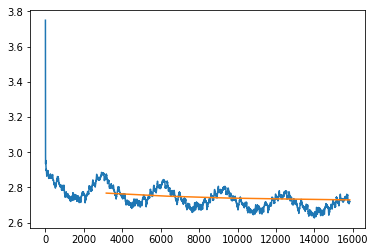

In [37]:
if TRAIN:
    learn.recorder.plot_losses()

## Text Generation

In [14]:
def generate_step(learner, context, context_length, temp=1):

    model = learner.model
    
    if GPU:
        context = LongTensor(context[-context_length:]).view(-1,1).cuda()
    else:
        context = LongTensor(context[-context_length:]).view(-1,1).cpu()
    
    context = torch.autograd.Variable(context)
    
    model.reset()
    model.eval()

    # forward pass the "context" into the model
    result, *_ = model(context)
    result = result[-1]

    # set unk and pad to 0 prob
    # i.e. never pick unknown or pad
    result[0] = -np.inf
    result[1] = -np.inf

    # softmax and normalize
    probabilities = F.softmax(result/temp, dim=0)
    probabilities = np.asarray(probabilities.detach().cpu(), dtype=np.float)
    probabilities /= np.sum(probabilities) 
    return probabilities

def print_words(context):
    for i in range(len(context)):
        
        step = context[i]

        word = data_lm.valid_ds.vocab.textify([step])

        if word == 'xeol':
            word = '\n'
        elif 'xbol' in word:
            word = word
        elif word == 'xeos': 
            print(word)
            break
            
        print(word, end=' ')   

def generate_text(learner, seed_text=['xbos'], max_len=500, GPU=False, context_length=20, beam_width=5, verbose=True, temp=1):
    """Generates text with a given learner and returns best options.

    Parameters
    ----------
    learner : RNNLearner Language Model (RNNLearner.language_model())
        Fastai RNNLearner with tokenized language model data already loaded 
        
    seed_text : list or str
        List of strings where each item is a token. (e.g. ['the', 'cat']) or string that is split on white space

    max_len : int
        Number of words in generated sequence
        
    gpu : bool
        If you're using a GPU or not...
    
    context_length : int
        Amount of words that get input as "context" into the model. Set to 0 for no limit   
        
    beam_width : int
        How many new word indices to try out...computationally expensive
    
    verbose : bool
        If True, prints every possible context for a given word cycle

    temperature : float
        Scales the logits before softmax. A higher temp (>1) increases variety whereas a low temp (<=1) will often result in a loop

    Returns
    -------
    context_and_scores : list of lists
        Returns a sorted list of the entire tree search of contexts and their respective scores in the form:
        [[context, score], [context, score], ..., [context, score]]
    """
        
    if isinstance(seed_text, str):
        seed_text = data_lm.train_ds.vocab.numericalize(seed_text.split(' '))
    
    
    # Width for the beam search, to be externalized along with general decoding
    beam_width = beam_width
    
    # List of candidate word sequence. We'll maintain #beam_width top sequences here.
    # The context is a list of words, the scores are the sum of the log probabilities of each word
    context_and_scores = [[seed_text, 0.0]]
    
    # Loop over max number of words
    for word_number in range(max_len):
        if verbose: print(f'Generating word: {word_number+1} / {max_len}')

        candidates = []
        
        # For each possible context that we've generated so far, generate new probabilities, 
        # and pick an additional #beam_width next candidates
        for i in range(len(context_and_scores)):
            # Get a new sequence of word indices and log-probability
            # Example: [[2, 138, 661], 23.181717]
            context, score = context_and_scores[i]
            
            # Obtain probabilities for next word given the context 
            probabilities = generate_step(learner, context, context_length, temp)

            # Multinomial draw from the probabilities
            multinom_draw = np.random.multinomial(beam_width, probabilities)
            top_probabilities = np.argwhere(multinom_draw != 0).flatten()
                        
            #For each possible new candidate, update the context and scores
            for j in range(len(top_probabilities)):
                next_word_idx = top_probabilities[j]
                new_context = context + [next_word_idx]
                candidate = [new_context, (score - np.log(probabilities[next_word_idx]))]
                candidates.append(candidate)
        
        #update the running tally of context and scores and sort by probability of each entry
        context_and_scores = candidates
        context_and_scores = sorted(context_and_scores, key = lambda x: x[1]) #sort by top entries
#         np.random.shuffle(context_and_scores)

        context_and_scores = context_and_scores[:15] #for now, only keep the top 15 to speed things up but we can/should change this to beam_width or something else
        
        if verbose:
            for context, score in context_and_scores:
                print_words(context)
                print('\n')
    
    return context_and_scores
    

In [95]:
final_scores = generate_text(learn, GPU=GPU, seed_text='xbos xbol-1', max_len=150, context_length=40, beam_width=3, verbose=False, temp=1.5)

In [96]:
#print all of the final options of songs
for song, score in final_scores:
    print_words(song)
    print(score)
    print('\n')

xbos xbol-1 ah , follows you 
 xbol-2 yeah , makes me wonder 
 xbol-3 
 xbol-4 what did i tell you 
 xbol-5 tell me what could i tell 
 xbol-6 ooh , tell me what 
 xbol-7 oh , tell me what did i do 
 xbol-8 (and what did you tell me ) 
 xbol-9 tell me what 
 xbol-10 tell me what ? 
 xbol-11 tell me what did i tell you 
 xbol-12 tell me what did i tell ya ? 
 xbol-13 tell me what did i tell you , baby ? 
 xbol-14 tell me what did i do ? 
 xbol-15 tell me what in the world 
 xbol-16 tell me what do i do ? 
 xbol-17 tell me what did i do ? 
 xbol-18 tell me what else can you do ? 
 xbol-19 tell me what do i do ? 235.67201448175786


xbos xbol-1 ah , follows you 
 xbol-2 yeah , makes me wonder 
 xbol-3 
 xbol-4 what did i tell you 
 xbol-5 tell me what could i tell 
 xbol-6 ooh , tell me what 
 xbol-7 oh , tell me what did i do 
 xbol-8 (and what did you tell me ) 
 xbol-9 tell me what 
 xbol-10 tell me what ? 
 xbol-11 tell me what did i tell you 
 xbol-12 tell me what did i tell ya ? 
 x